In [163]:
import pandas as pd
import pandahouse as ph
from fbprophet import Prophet

import matplotlib.pyplot as plt

In [140]:
ph_connection = {'connection to db'}

q = '''
    select date,
        toInt32(sum(ggr * cr.rate)) as ggr_usd
    from bi.all_coupons as ac
    join dwh_mb.users as u
    on u.id = ac.user_id
    join (select id, code from dwh_mb.currency) as c
        on u.currency = c.id
    join dwh_mb.currency_rate as cr
    on cr.rate_date = ac.date
        and cr.currency = c.code
    group by date
    '''
    
df = ph.read_clickhouse(query=q, connection=ph_connection)

In [164]:
plt.figure(figsize=(30, 10))

plt.plot(df.date, df.ggr_usd, color='lightblue', alpha=0.5)
plt.plot(df.date, df.ggr_usd.rolling(30).mean(), color='orange')

plt.title('value by time')
plt.ylabel('millions, usd')
plt.xlabel('date')

plt.legend(['Raw data', 'Rolling mean'], fontsize=18)

AttributeError: 'DataFrame' object has no attribute 'date'

<Figure size 2160x720 with 0 Axes>

In [142]:
df = df.rename(columns={'date': 'ds',
                   'ggr_usd': 'y'})

In [143]:
pred_model = Prophet(weekly_seasonality=True, yearly_seasonality=True)

In [144]:
periods = 30
train_df = df[:-periods]

In [145]:
pred_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -93.6496


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3653.61       0.18331       284.704           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3666.4    0.00639598       94.9496      0.7207      0.7207      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3668.72   0.000155752       112.483   8.762e-07       0.001      317  LS failed, Hessian reset 
     299       3670.81   0.000604189       93.9707           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       3672.93    0.00045161        255.12   3.078e-06       0.001      513  LS failed, Hessian reset 
     399       3673.68   0.000439935       90.7346           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha

In [159]:
forecast_df = pred_model.make_future_dataframe(freq='D', periods=periods)

In [160]:
forecast = pred_model.predict(forecast_df)

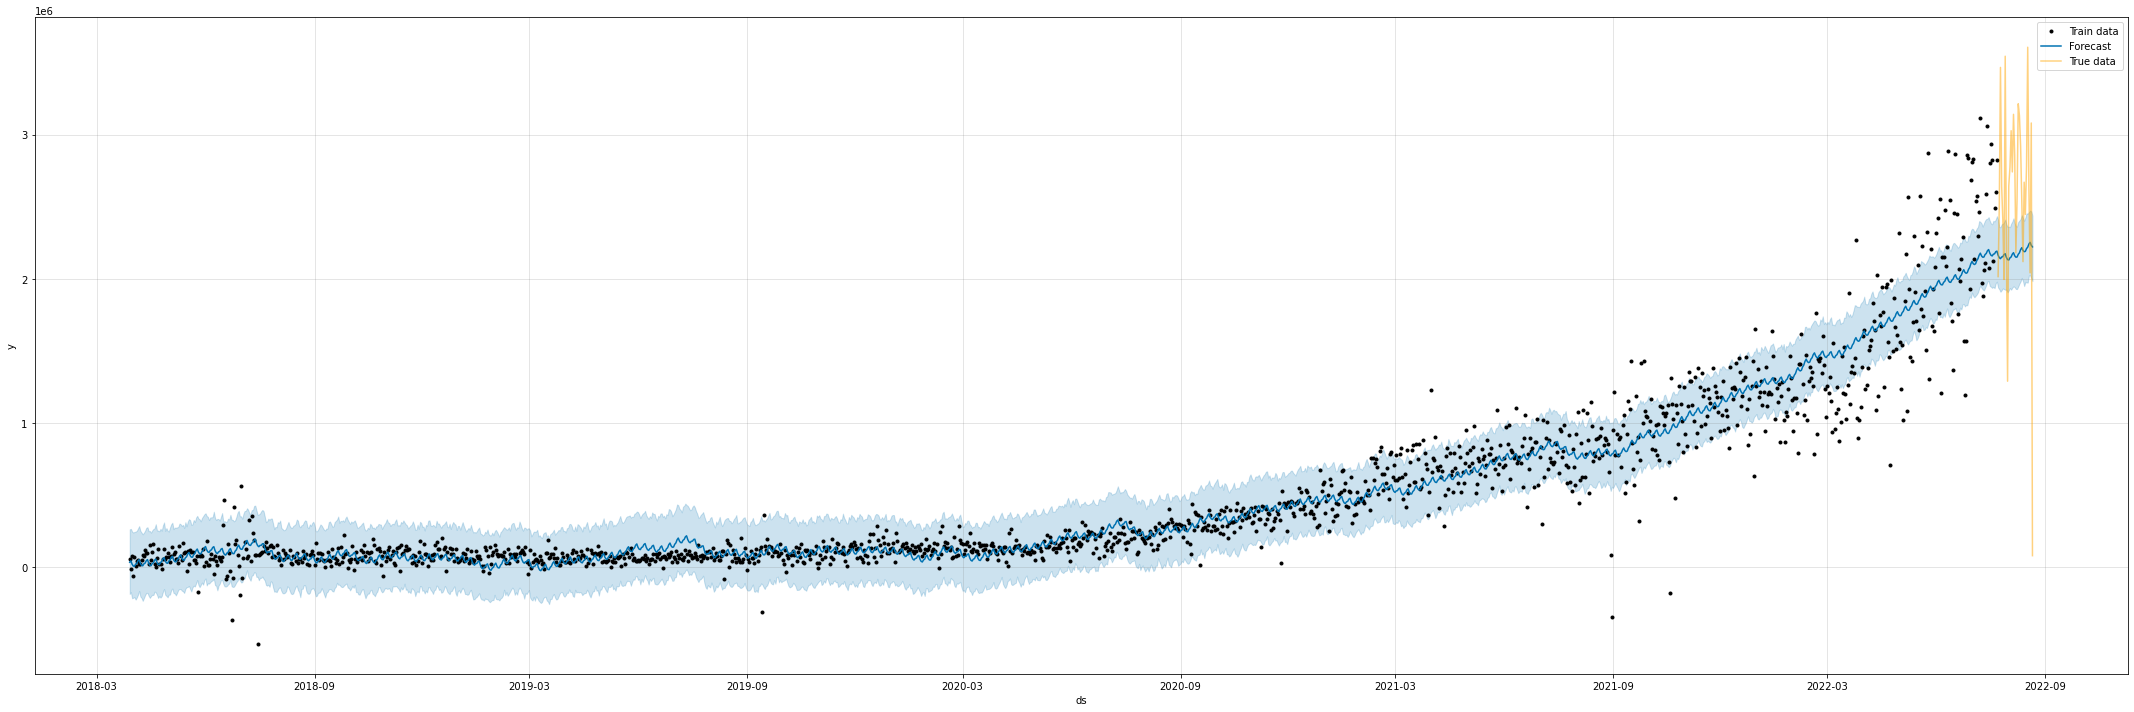

In [161]:
pred_model.plot(forecast, figsize=(30, 10));
plt.plot(df.ds[-periods:], df.y[-periods:], color='orange', alpha=0.5)
plt.legend(['Train data', 'Forecast', 'True data'])

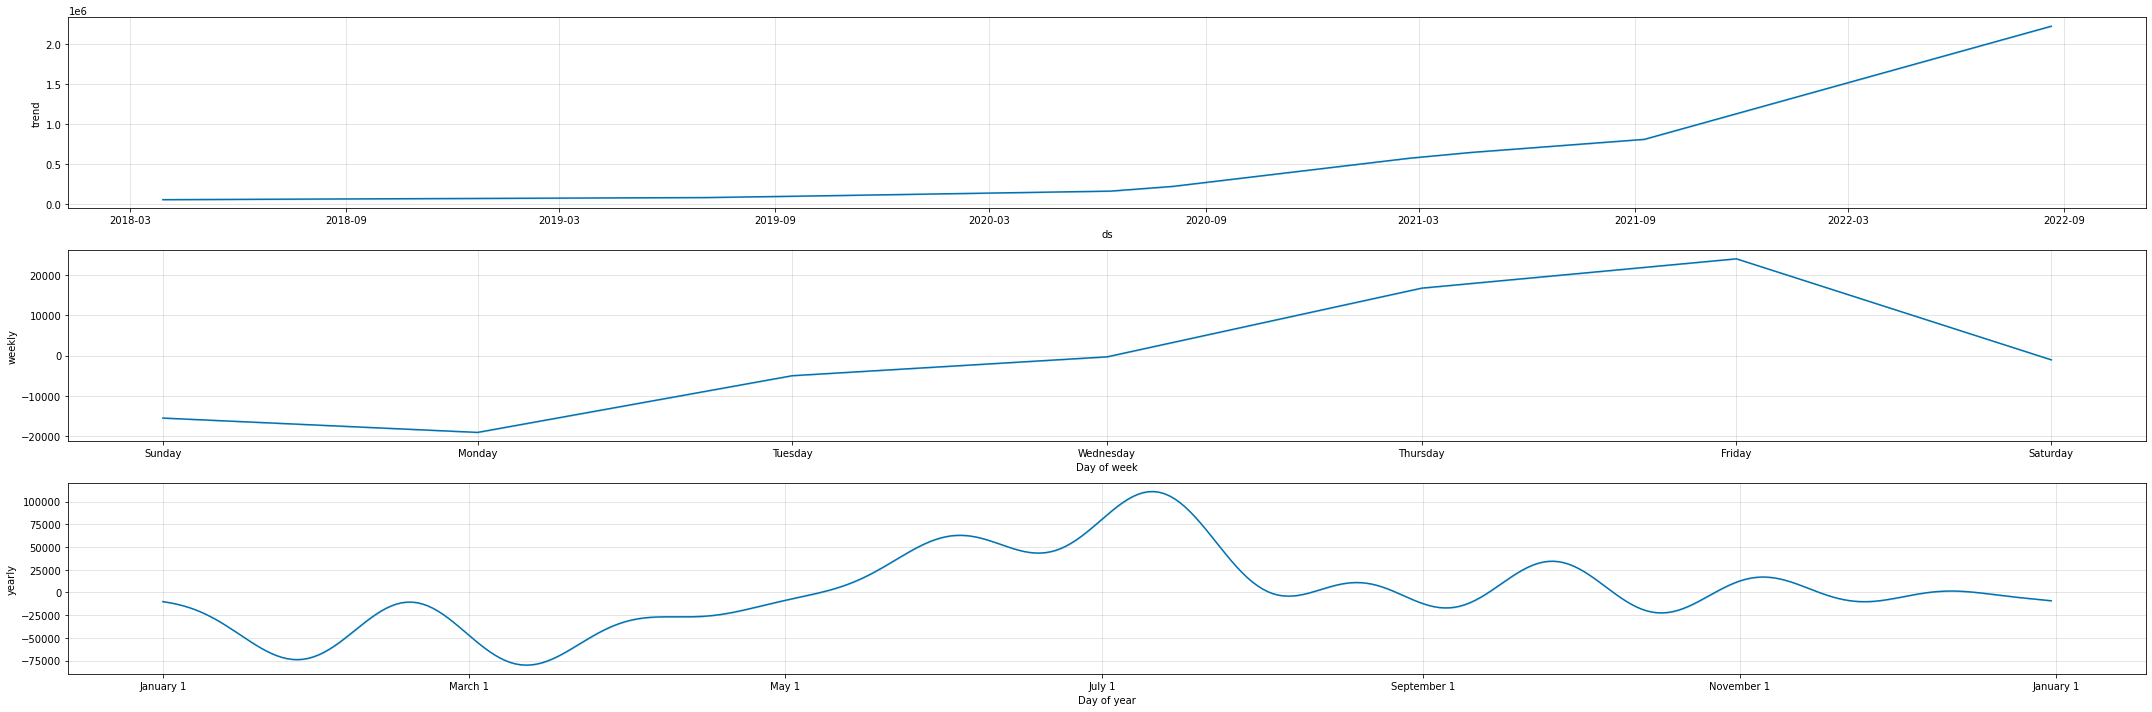

In [162]:
pred_model.plot_components(forecast, figsize=(30, 10));